In [2]:
import tensorflow as tf
from keras.layers import LSTM, GRU, Dense, Embedding, Dropout , Conv1D , GlobalMaxPool1D
from keras.preprocessing import text, sequence
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.utils.data_utils import pad_sequences
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


In [3]:
kdnugget_dataset = pd.read_csv("fake_and_real_news_dataset.csv")
# print(kdnugget_dataset)
true = kdnugget_dataset[kdnugget_dataset["label"] == "REAL" ]
fake = kdnugget_dataset[kdnugget_dataset["label"] == "FAKE" ]
fake

,idd,title,text,label
2297,oVh@3GbDzG,Trump Vows Personal Campaign Spending Will Tot...,2016 US Presidential Election ( 45 ) 0 14 0 0 ...,FAKE
2298,ydS(bOFlM%,WikiLeaks: Neera Tanden describes Clinton shen...,"— jewels (@Jewels817) October 28, 2016 \nNeera...",FAKE
2299,qKo*nzJz70,No charges after new review of Hillary Clinton...,39 Shoina is a village drowned up to the wai...,FAKE
2300,y@p(^ymHf&,AIG Quadruples Limits for Terrorism Insurance ...,« on: Today at 08:36:35 PM » AIG Quadruples Li...,FAKE
2301,@51o%byOAS,Trump Whistles His Dogs,"By Gilad Atzmon on November 2, 2016 Jews see i...",FAKE
...,...,...,...,...
4589,ukZm6JTO#x,Russia Calls the War Party's Bluff,License DMCA \nCold War 2.0 has reached unprec...,FAKE
4590,yu0xKEiapJ,Bernie Sanders: The Democratic primary gave me...,Print \nSen. Bernie Sanders laid out the ways ...,FAKE
4591,c4Y370E_9c,"Pipeline Police Strip Search Native Girl, Then...",As the pressure to start construction on the D...,FAKE
4592,bBbeuCUeMH,Currency Crisis: Alasdair MacLeod On The Vexed...,Tweet Home » Gold » Gold News » Currency Crisi...,FAKE


In [4]:
true['truth'] = 1
fake['truth'] = 0
df = pd.concat([true, fake], axis=0, ignore_index=True)
df.shape
print(df)

             idd                                              title  \
0     Fq+C96tcx+  ‘A target on Roe v. Wade ’: Oklahoma bill maki...   
1     bHUqK!pgmv  Study: women had to drive 4 times farther afte...   
2     4Y4Ubf%aTi        Trump, Clinton clash in dueling DC speeches   
3     _CoY89SJ@K  Grand jury in Texas indicts activists behind P...   
4     +rJHoRQVLe  As Reproductive Rights Hang In The Balance, De...   
...          ...                                                ...   
4589  ukZm6JTO#x                 Russia Calls the War Party's Bluff   
4590  yu0xKEiapJ  Bernie Sanders: The Democratic primary gave me...   
4591  c4Y370E_9c  Pipeline Police Strip Search Native Girl, Then...   
4592  bBbeuCUeMH  Currency Crisis: Alasdair MacLeod On The Vexed...   
4593  vE44sWBnd9                   Paper Tiger ISIS Digs Into Mosul   

                                                   text label  truth  
0     UPDATE: Gov. Fallin vetoed the bill on Friday....  REAL      1  
1    

C:\Users\ALI\AppData\Local\Temp\ipykernel_20224\834554012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true['truth'] = 1
C:\Users\ALI\AppData\Local\Temp\ipykernel_20224\834554012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake['truth'] = 0


In [19]:
def clean_text(txt):

    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
    
    # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    cleaned_text = ' '.join(words)
    return cleaned_text

df['data_cleaned'] = df['title'].apply(lambda txt: clean_text(txt) if type(txt) != float else str(txt))


In [20]:
xtrain, xtest, ytrain, ytest = train_test_split(df['data_cleaned'], df['truth'], shuffle=True, test_size=0.2)
# find the length of the largest sentence in training data
max_len = xtrain.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 227


In [21]:
max_words = 10000
tokenizer = text.Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(xtrain)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

# pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index

print('Text Example:', xtrain[0])
print('Sequence of indices(before padding):', xtrain_seq[0])
print('Sequence of indices(after padding):', xtrain_pad[0])

Text Example: A target Roe v Wade Oklahoma bill making felony perform abortions waits governor decision
Sequence of indices(before padding): [2, 202, 25, 693, 122, 540, 103, 110, 1205, 36, 111, 3364]
Sequence of indices(after padding): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

## Word embedding using pre-trained GloVe vectors


In [22]:
embedding_vectors = {}
with open('glove.twitter.27B.100d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")   


Size of vocabulary in GloVe: 1193514


In [23]:
#initialize the embedding_matrix with zeros
emb_dim = 100
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')

Some out of valubulary words: ['antitrump', 'truthfeed', 'brexit', 'egyptair', 'hillarys']


In [24]:
def eval_model(true_value, predict_value):
    print("accuracy:  ", accuracy_score(true_value, predict_value))
    print("Precision:  ", precision_score(true_value, predict_value))
    print("Recall:  ", recall_score(true_value, predict_value))
    print("F1 score:  ", f1_score(true_value, predict_value))

## LSTM

In [25]:
vocab_len

10000

In [26]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dense(32, activation = 'sigmoid'))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          42240     
                                                                 
 lstm_3 (LSTM)               (None, 128)               98816     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,145,217
Trainable params: 145,217
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [28]:
batch_size = 256
epochs  = 10
history = lstm_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)


Epoch 1/10
15/15 [==============================] - 29s 2s/step - loss: 0.6610 - accuracy: 0.6024 - val_loss: 0.5659 - val_accuracy: 0.7399
Epoch 2/10
15/15 [==============================] - 28s 2s/step - loss: 0.5116 - accuracy: 0.7725 - val_loss: 0.4896 - val_accuracy: 0.7769
Epoch 3/10
15/15 [==============================] - 29s 2s/step - loss: 0.4541 - accuracy: 0.8008 - val_loss: 0.4675 - val_accuracy: 0.7900
Epoch 4/10
15/15 [==============================] - 30s 2s/step - loss: 0.4274 - accuracy: 0.8188 - val_loss: 0.4321 - val_accuracy: 0.8128
Epoch 5/10
15/15 [==============================] - 31s 2s/step - loss: 0.4032 - accuracy: 0.8316 - val_loss: 0.4135 - val_accuracy: 0.8292
Epoch 6/10
15/15 [==============================] - 31s 2s/step - loss: 0.3867 - accuracy: 0.8435 - val_loss: 0.3968 - val_accuracy: 0.8357
Epoch 7/10
15/15 [==============================] - 30s 2s/step - loss: 0.3706 - accuracy: 0.8463 - val_loss: 0.3905 - val_accuracy: 0.8455
Epoch 8/10
15/15 [==

In [29]:
lstm_model.save("lstm_model_kdnugget.h5")

Text(0.5, 1.0, 'Accuracy')

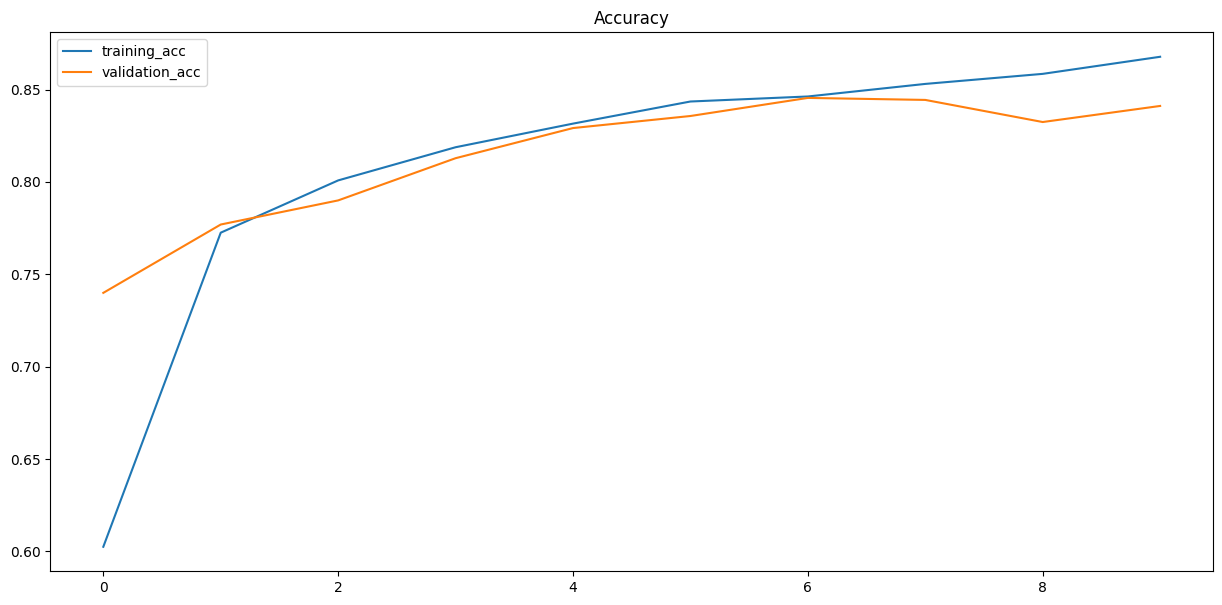

In [30]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [31]:
predict_y = lstm_model.predict(xtest_pad)
eval_model(np.array(ytest).astype(int), predict_y.round())

29/29 [==============================] - 3s 82ms/step
accuracy:   0.8411316648531012
Precision:   0.8322851153039832
Recall:   0.857451403887689
F1 score:   0.8446808510638297


## GRU

In [32]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,088,449
Trainable params: 88,449
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [33]:
batch_size = 256
epochs  = 10
history = gru_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)


Epoch 1/10
15/15 [==============================] - 11s 646ms/step - loss: 0.6428 - accuracy: 0.6256 - val_loss: 0.5359 - val_accuracy: 0.7693
Epoch 2/10
15/15 [==============================] - 9s 574ms/step - loss: 0.4984 - accuracy: 0.7690 - val_loss: 0.4679 - val_accuracy: 0.7889
Epoch 3/10
15/15 [==============================] - 8s 555ms/step - loss: 0.4392 - accuracy: 0.7989 - val_loss: 0.4290 - val_accuracy: 0.8074
Epoch 4/10
15/15 [==============================] - 8s 558ms/step - loss: 0.4064 - accuracy: 0.8150 - val_loss: 0.4186 - val_accuracy: 0.8107
Epoch 5/10
15/15 [==============================] - 9s 580ms/step - loss: 0.3880 - accuracy: 0.8226 - val_loss: 0.4106 - val_accuracy: 0.8150
Epoch 6/10
15/15 [==============================] - 9s 617ms/step - loss: 0.3763 - accuracy: 0.8335 - val_loss: 0.4029 - val_accuracy: 0.8215
Epoch 7/10
15/15 [==============================] - 9s 621ms/step - loss: 0.3664 - accuracy: 0.8351 - val_loss: 0.3850 - val_accuracy: 0.8270
Epoch

In [34]:
gru_model.save("gru_model_kdnugget.h5")

Text(0.5, 1.0, 'Accuracy')

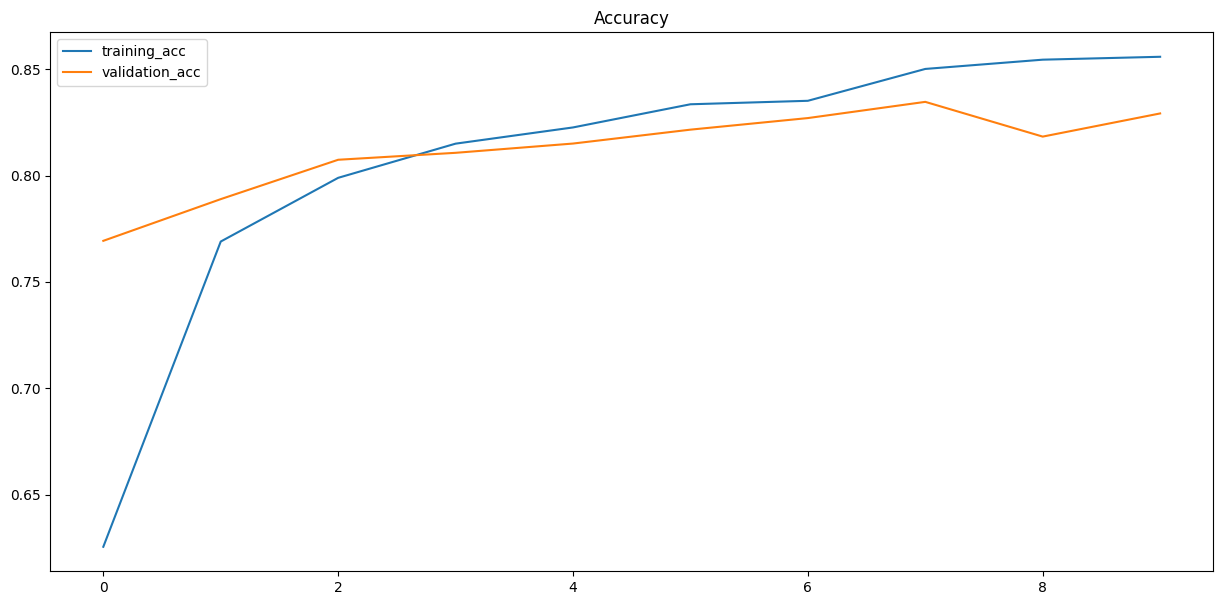

In [35]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [36]:
predict_y = gru_model.predict(xtest_pad)
eval_model(np.array(ytest).astype(int), predict_y.round())

29/29 [==============================] - 1s 25ms/step
accuracy:   0.8291621327529923
Precision:   0.8415178571428571
Recall:   0.8142548596112311
F1 score:   0.827661909989023


## CNN

In [37]:
emb_dim = embedding_matrix.shape[1]
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(128 , kernel_size=4))
cnn_model.add(GlobalMaxPool1D())
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(128, activation = 'sigmoid'))
cnn_model.add(Dense(1, activation = 'sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         1000000   
                                                                 
 dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         51328     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                      

In [38]:
batch_size = 256
epochs  = 10
history = cnn_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)


Epoch 1/10
15/15 [==============================] - 2s 112ms/step - loss: 0.6523 - accuracy: 0.6286 - val_loss: 0.5772 - val_accuracy: 0.7476
Epoch 2/10
15/15 [==============================] - 1s 100ms/step - loss: 0.5332 - accuracy: 0.7644 - val_loss: 0.4868 - val_accuracy: 0.7693
Epoch 3/10
15/15 [==============================] - 2s 105ms/step - loss: 0.4728 - accuracy: 0.7804 - val_loss: 0.4553 - val_accuracy: 0.7889
Epoch 4/10
15/15 [==============================] - 2s 103ms/step - loss: 0.4346 - accuracy: 0.8131 - val_loss: 0.4508 - val_accuracy: 0.7867
Epoch 5/10
15/15 [==============================] - 2s 102ms/step - loss: 0.4088 - accuracy: 0.8182 - val_loss: 0.4327 - val_accuracy: 0.8020
Epoch 6/10
15/15 [==============================] - 2s 102ms/step - loss: 0.3952 - accuracy: 0.8239 - val_loss: 0.4150 - val_accuracy: 0.8041
Epoch 7/10
15/15 [==============================] - 1s 101ms/step - loss: 0.3692 - accuracy: 0.8359 - val_loss: 0.4006 - val_accuracy: 0.8139
Epoch 

In [39]:
cnn_model.save("cnn_model_kdnugget.h5")

Text(0.5, 1.0, 'Accuracy')

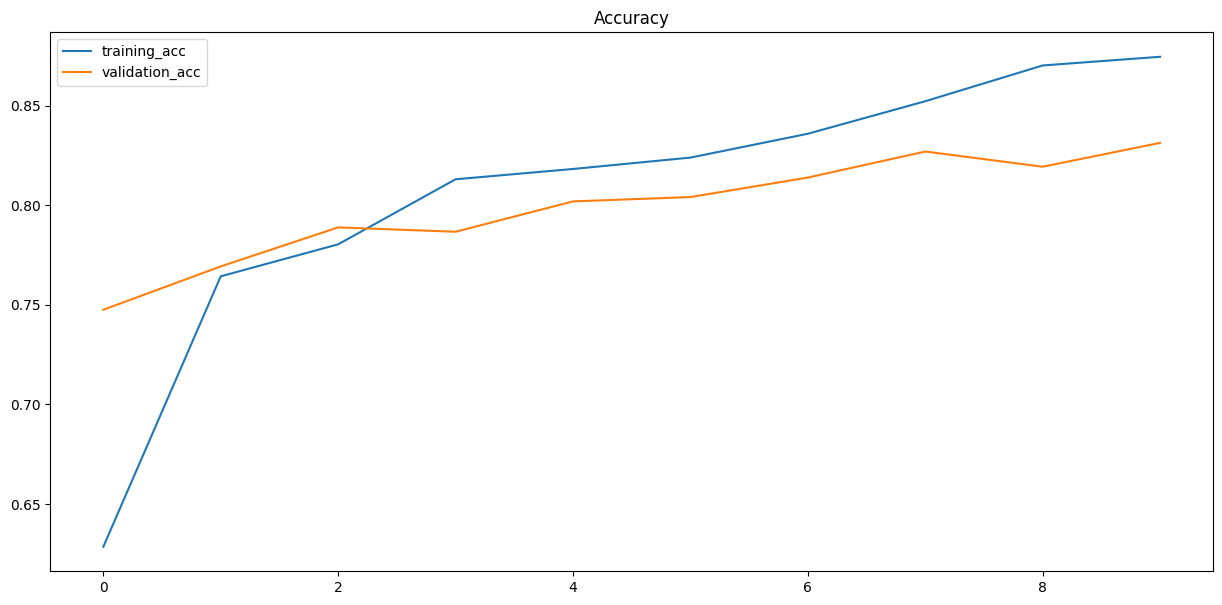

In [40]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [41]:
predict_y = cnn_model.predict(xtest_pad)
eval_model(np.array(ytest).astype(int), predict_y.round())

29/29 [==============================] - 0s 5ms/step
accuracy:   0.8313384113166485
Precision:   0.7927756653992395
Recall:   0.9006479481641468
F1 score:   0.8432760364004044
